In [2]:
#import pdb; pdb.set_trace()
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pdp

# Jupyter Notebookの中でインライン表示する場合の設定（これが無いと別ウィンドウでグラフが開く）
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/probspace')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
train.head(10)

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
4,4,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
5,5,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
6,6,100000,2,2,2,23,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
7,7,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
8,8,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0
9,9,200000,2,3,2,34,0,0,2,0,0,-1,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0


In [0]:
columns = ["id", "credit", "gender", "education", "marrage", "age"]
columns += [f"payment_{i}" for i in range(9,3,-1)]
columns += [f"claim_{i}" for i in range(9,3,-1)]
columns += [f"advance_{i}" for i in range(9,3,-1)]
train.columns = columns + ["target"]
test.columns = columns

In [55]:
train.head(10)

,id,credit,gender,education,marrage,age,payment_9,payment_8,payment_7,payment_6,payment_5,payment_4,claim_9,claim_8,claim_7,claim_6,claim_5,claim_4,advance_9,advance_8,advance_7,advance_6,advance_5,advance_4,target,payment
0,0,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1
1,1,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1
2,2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0
3,3,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0
4,4,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0,0
5,5,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,0
6,6,100000,2,2,2,23,0,0,0,0,0,0,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0
7,7,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,1
8,8,20000,1,3,2,35,0,0,0,0,0,0,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0,0
9,9,200000,2,3,2,34,0,0,2,0,0,0,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0,1


In [0]:
'''
#年齢台の特徴量
train["age_cat"] = (np.floor(train["age"]/10)*10).astype(np.int64)
test["age_cat"] = (np.floor(test["age"]/10)*10).astype(np.int64)
'''

column_names = [f"payment_{i}" for i in range(9,3,-1)]

train["payment"] =  0
test["payment"] =  0

for column_name in column_names:
    train.loc[train[column_name] < 0, column_name] = 0
    test.loc[train[column_name] < 0, column_name] = 0
    
    

#row は遅い
for index, row in train.iterrows():    
    if any(row[column_names]) == True:
      train.loc[index, "payment"] = 1
      
for index, row in test.iterrows():    
    if any(row[column_names]) == True:
      test.loc[index, "payment"] = 1

   


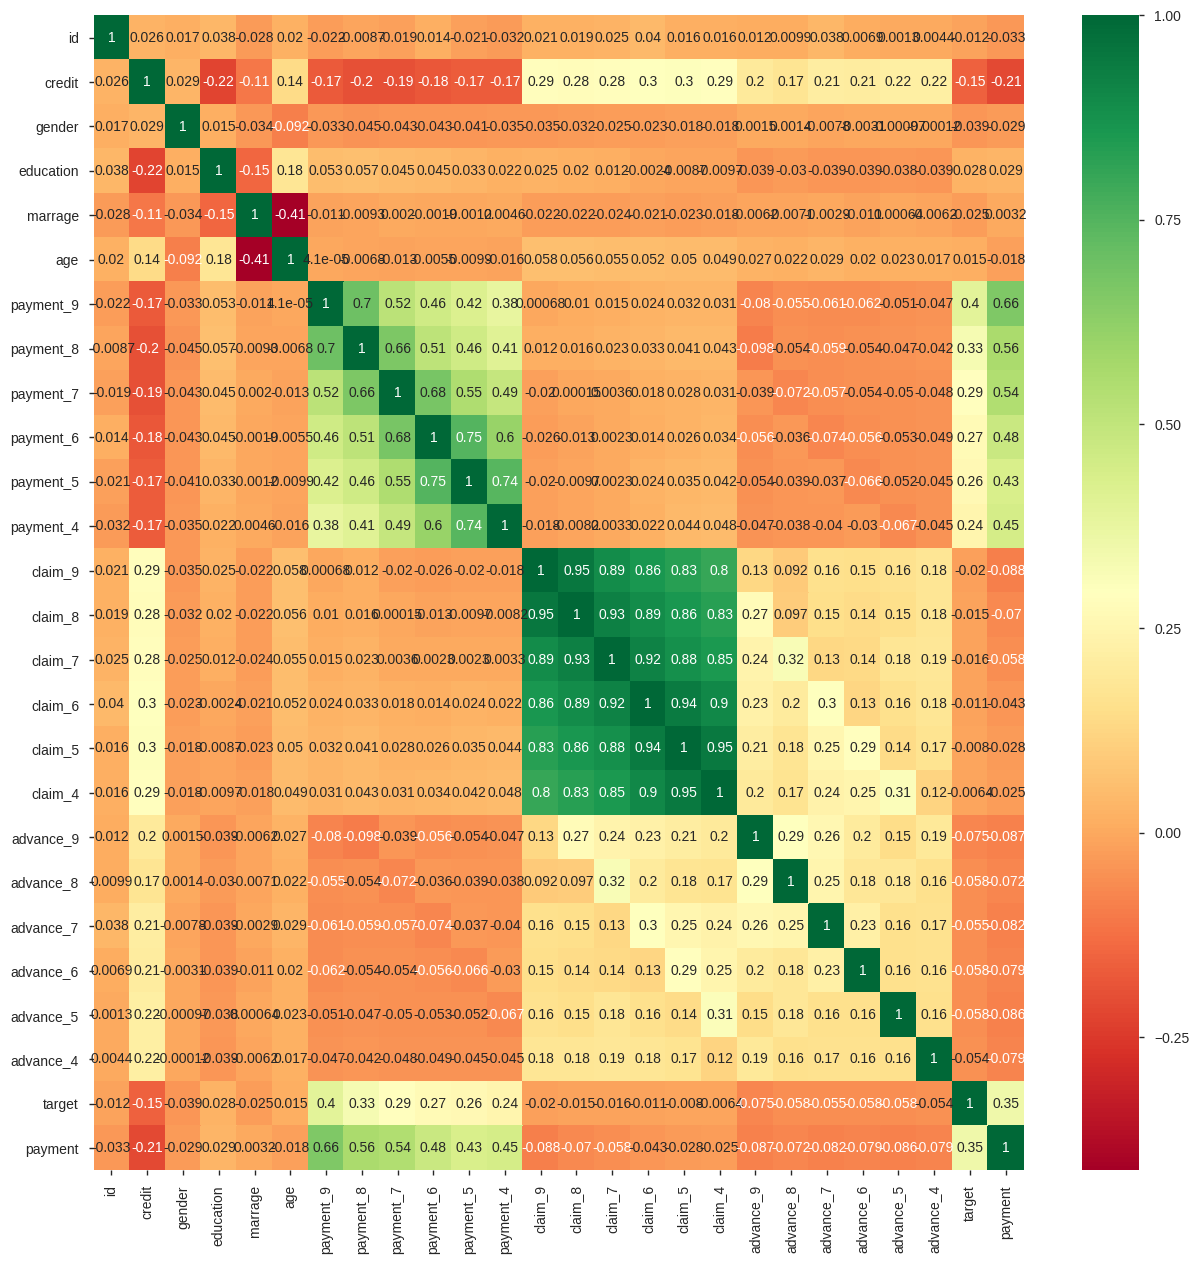

In [56]:
#とりあえず相関を見てみる
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["target"])>-10]
plt.figure(figsize=(15,15))
g = sns.heatmap(train[top_corr_features].corr(), annot = True, cmap="RdYlGn")

In [9]:
#NaNの対処
nuls = pd.DataFrame(train.isnull().sum().sort_values(ascending = False)[:10])
nuls.columns = ['Null Count']
nuls.index.name = 'Feature'
nuls

,Null Count
Feature,
target,0
payment_4,0
credit,0
gender,0
education,0
marrage,0
age,0
payment_9,0
payment_8,0


In [10]:
pdp.ProfileReport(train)

Number of variables,25
Number of observations,27000
Total Missing (%),0.0%
Total size in memory,5.1 MiB
Average record size in memory,200.0 B
Numeric,18
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


In [11]:
train.dtypes
#gender education age target をカテゴリ型に変換したい

id           int64
credit       int64
gender       int64
education    int64
marrage      int64
age          int64
payment_9    int64
payment_8    int64
payment_7    int64
payment_6    int64
payment_5    int64
payment_4    int64
claim_9      int64
claim_8      int64
claim_7      int64
claim_6      int64
claim_5      int64
claim_4      int64
advance_9    int64
advance_8    int64
advance_7    int64
advance_6    int64
advance_5    int64
advance_4    int64
target       int64
dtype: object

In [0]:
#トレーニングデータの分割
y = train.target 
X = train.drop(['id','target'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

In [59]:
#xgb 0830 RMSE: 0.1801851851851852
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=100)


model_xgb.fit(X_train, y_train, verbose=False)
preds = model_xgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18074074074074073 


In [64]:
#xgb 0830 RMSE: 0.1814814814814815  
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBClassifier(max_depth=2, learning_rate=0.05, n_estimators=100)


model_xgb.fit(X_train, y_train, verbose=False)
preds = model_xgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18166666666666667 


In [65]:
#xgbテストデータで予測したtarget値をCSVに出力
XGBMd = model_xgb.predict(test.drop(['id'], axis=1))

submit= pd.DataFrame()
submit['ID'] = test.id
submit['Y'] = XGBMd

submit.to_csv('xgb_submit.csv', index=False)
print('XGB submission file created')

XGB submission file created


In [0]:
#light gbm　0832 RMSE: 0.1787037037037037  
#we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(max_depth=7, learning_rate=0.05, num_leaves=31, n_estimators=100)


model_lgb.fit(X_train, y_train, verbose=False)
preds = model_lgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.1787037037037037  


In [16]:
#light gbm　0832 RMSE: 0.1787037037037037  
#we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(max_depth=1, learning_rate=0.05, num_leaves=31, n_estimators=100)


model_lgb.fit(X_train, y_train, verbose=False)
preds = model_lgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18314814814814814 


In [0]:
#lgbテストデータで予測したtarget値をCSVに出力
LGBMd = model_lgb.predict(test.drop(['id'], axis=1))

submit= pd.DataFrame()
submit['ID'] = test.id
submit['Y'] = LGBMd

submit.to_csv('lgb_submit.csv', index=False)
print('LGB submission file created')

LGB submission file created
